Homework 3 — (15 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files).

Note: Make sure to include all the files that are required for the notebook to run **from the submission folder** (e.g. trumpet.wav). Points will be taken off from submissions that crash because Python cannot find the specified files.

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. 
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

## Run this code block 1st, to import the needed packages

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline



/Users/olivergoodman/miniconda2/envs/eecs352/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Some Helpful Code

In [2]:

from scipy.fftpack import fft
from scipy.signal import hann

def wavwrite(filepath, data, sr, norm=True, dtype='int16'):
    '''
    Write wave file using scipy.io.wavefile.write, converting from a float (-1.0 : 1.0) numpy array to an integer array
    
    Parameters
    ----------
    filepath : str
        The path of the output .wav file
    data : np.array
        The float-type audio array
    sr : int
        The sampling rate
    norm : bool
        If True, normalize the audio to -1.0 to 1.0 before converting integer
    dtype : str
        The output type. Typically leave this at the default of 'int16'.
    '''
    if norm:
        data /= np.max(np.abs(data))
    data = data * np.iinfo(dtype).max
    data = data.astype(dtype)
    sp.io.wavfile.write(filepath, sr, data)
    
#-----------------------------------------------------------
# Here's an stft implementation. Yes, it doesn't bother to get the last little bit of audio.
   
def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = 1 + length_to_cover_with_hops/hop_size;
    
    # make our window function
    if window_type == 'hann':
        window = hann(window_size)
    elif window_type=='rectangular':
        window = np.ones(window_size)
    else:
        raise Exception('Invalid window type. Must be "hann" or "rectangular".')
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft)

#-----------------------------------------------------------
# here's a spectrogram implementation

def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = True ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: a bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 

    # get the stft
    X = stft(signal, window_size, hop_size, window_type)

    # figure out what my window start times are
    times = np.arange(len(X))
    hop_in_secs = hop_size/(1.0 * sample_rate)
    times = times * hop_in_secs
    
    # chop off everything above the nyquist rate & rotate for display    
    X = np.rot90(X,3)
    sgram = np.array(X[0:len(X)/2])

    # figure out what my frequencies of analysis are..
    analysis_f0 = sample_rate/window_size
    freqs = np.arange(len(sgram)) * analysis_f0
    
    # turn the complex values into magnitudes and putit into a log scale 
    sgram = np.abs(sgram) + 0.00000000000001  # this prevents taking the log of 0
    log_sgram = 20 * np.log10(sgram)
 
    # plot the spectrum 
    if display: 
        plt.figure()
        x_coord = np.tile(times,(len(freqs),1)) 
        x_coord = np.fliplr(x_coord)
        y_coord = np.tile(freqs,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,log_sgram)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])

        plt.title('Magnitude Spectrogram in dB')
        plt.xlabel('time in seconds')
        plt.ylabel('frequency in Hz')
        cbar = plt.colorbar()

    return np.rot90(log_sgram,1), times, freqs
#--------------------------------------
# A couple of helper functions to make mels into frequencies and vice versa

def mel2freq(mel):
    freq = 700.0 * (-1.0 + 10.0**(mel/2595.0))
    return freq

def freq2mel(freq):
    x = 1.0 + freq/700.0
    mel = 2595 * np.log10(x)
    return mel

#-----------------------------------------------------------
# Exactly what it says it is...

def make_triangular_filters(cfreqs,freqs,nyquist):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis from your Fourier transform (freqs) as input, both coded in Hz.  It will 
    return a 2-D numpy array filters[c][f], where c is the index number of a center 
    frequency in cfreqs and f is the index to a frequency in freqs and the value in 
    filters[c][f] gives the filter magnitude (a number between 0 and 1 that represents 
    how sensitive this filter is to that frequency). 
    
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency. The lowest center frequency will decrease to 0 by 
    0 Hz on the low end. The highest center frequency will decrease to 0 by the 
    Nyquist frequency on the high end.
    
    Note: you do not have to normalize the filters by energy in this exercise 
    (the maximum magnitude for all filters is equal to 1).
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter (also measured in Hz)
    nyquist: the frequency of the nyquist rate. By default, the filter with the highest 
            center frequency will have its response reach 0 at the nyquist frequency. 
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
            
    """
     
    assert min(freqs)<=min(cfreqs) and max(freqs)>=max(cfreqs), "cfreqs range must be within freqs range."

    filters = np.zeros((len(cfreqs), len(freqs)))
        
    for c in range(0,len(cfreqs)):
        if c==0: 
            # if we're on the first cfreq, use 0 for the low frequency
            low_freq = 0 
            high_freq = cfreqs[c+1]
        elif c==(len(cfreqs)-1):
            # if we're on the last cfreq, use nyquist for the high frequency
            low_freq = cfreqs[c-1]
            high_freq = nyquist 
        else:
            low_freq = cfreqs[c-1]
            high_freq = cfreqs[c+1]
  
        for f in range(len(freqs)):
            
            if (freqs[f]> cfreqs[c]):
                x = freqs[f]
                b = -high_freq / float(cfreqs[c]-high_freq) # offset
                a = 1./(cfreqs[c]-high_freq) # slope
                filters[c][f] = max([a*x+b,0.])
                    
            elif (freqs[f]< cfreqs[c]):
                x = freqs[f]
                b = -low_freq / float(cfreqs[c]-low_freq) # offset
                a = 1./(cfreqs[c]-low_freq) # slope
                filters[c][f] = max([a*x+b,0.])
            else:
                filters[c][f] = 1.0
    return filters

def make_sinewave(f, t, sr):
    """    
    Parameters
    ----------
    f:  float
        Frequency of sine wave
    t:  float
        Duration in seconds
    sr: int
        Sample rate
    
    Returns
    -------
    np.ndarray 
        Array of floats containing the signal
    """
    time = np.arange(0,t*sr)/sr
    sine_wave = np.sin(2*np.pi*f*time)
    return sine_wave

#### 1. (2 points) Make a log spectrogram function that lets you use either log2 spacing or mel frequency spacing..  

$m = 2595log_{10}(1+\frac{f}{700})$

(1) Douglas O'Shaughnessy (1987). Speech communication: human and machine. Addison-Wesley. p. 150. ISBN 978-0-201-16520-3.

In [3]:
def log_spectrogram(signal, window_size, hop_size, sample_rate, num_channels, channel_spacing = 'mel', display = True ):
    """
    Builds a mel-frequency spectrogram. Computes the short term fourier transform of a 1-D numpy array 
    (the signal). It then creates a magnitude spectrogram of the signal and then remaps the energy num_channels
    frequency bins, spaced evenly in the log (or mel) frequency domain between the top key of the piano (4186 Hz) and 
    the bottom key of the piano (27.5 Hz). The vertical dimension is the index number of 
    the frequency channel. The horizontal dimension is time(in seconds), brightness corresponds to 
    amplitude (in dB). Only frequencies up to the top of the piano are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    num_channels: how many frequency bins to put the energy into
    channel_spacing: if 'mel', then space evenly in the mel range. Else, evenly in log2(freq)
            *NOTE* if you pick 88 channels and log2 spacing, this places a bin at each piano key
    display: a bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    lgram: a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram.
           lgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the pitch note of the piano (4186 Hz)
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency bin in Hz. These are spaced evenly in the log2 of the frequency in Hz,
           with 12 to an octave. 
           
    Calling Example
    ---------------
    lgram,times,freqs = log_spectrogram(signal, window_size, hop_size, sample_rate, num_channels )

    """ 
    # the frequency domain
    top_piano_note =  440*2**(39.0/12)
    bottom_piano_note = 440*2**(-48.0/12)
    
    if channel_spacing == 'mel':
        mel_top = freq2mel(top_piano_note)
        mel_bottom = freq2mel(bottom_piano_note)
        mel_space = np.linspace(mel_bottom, mel_top, num_channels)
        cfreqs = mel2freq(mel_space)
    else:
        log2_top = np.log2(top_piano_note)
        log2_bottom = np.log2(bottom_piano_note)
        log2_space = np.linspace(log2_bottom, log2_top, num_channels)
        cfreqs = np.power(2, log2_space)

    sgram, times, freqs = spectrogram(signal, window_size, hop_size, sample_rate, display=False)
    filters = make_triangular_filters(cfreqs, freqs, top_piano_note)
    
    indices = np.linspace(1, num_channels, num_channels)
    
    
    sgram = np.matrix(sgram)
    lgram = np.array(filters * sgram.T)
    
    if display:
        plt.figure()
        x_coord = np.tile(times,(len(indices),1)) 
        y_coord = np.tile(indices,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,lgram)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])
        
        if channel_spacing == 'mel':
            plt.title('Mel-Frequency Spectrogram')
        else:
            plt.title('Log2-Frequency Spectrogram')
        plt.xlabel('Time (sec)')
        plt.ylabel('Index')
        cbar = plt.colorbar()
    

    return lgram, times, freqs

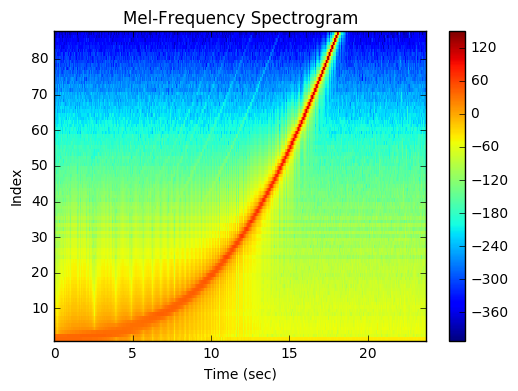

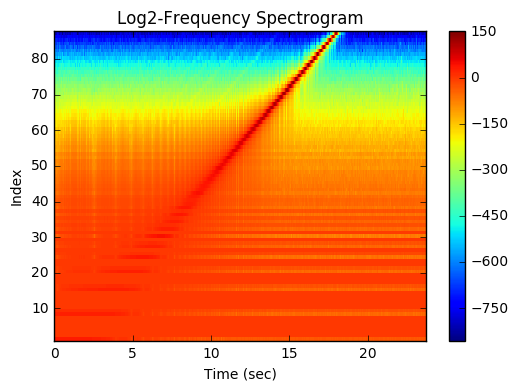

In [4]:
# you should probably write something to test your code here.
sinesweep, sr = librosa.load('sinesweep.wav', sr=44100, duration=24)
mel_lgram, times, freqs = log_spectrogram(sinesweep, 2048, 1024, sr, 88, channel_spacing='mel', display=True)
log2_legram, times, freqs = log_spectrogram(sinesweep, 2048, 1024, sr, 88, channel_spacing='log2', display=True)


### 2. ( 2 points) Make a chromagram. 

In [5]:
def chromagram(signal, window_size, hop_size, sample_rate, bins_per_pitchclass = 10, display = True):
    """
    Computes a SIMPLE chromagram of the signal and plots it on the screen. By SIMPLE chromagram,
    I mean that each chroma bin only gets energy from frequencies that fall within the width of the bin.
    Another way of putting that is: Only energy around powers of 2 of the same frequencies share a chroma bin.
    Another way of putting that is no energy from odd harmonics placed in a bin. 
    
    Here, the vertical dimension is chroma from 0 to 1 (AKA pitch class put on a scale from 0 to 1), 
    the horizontal dimension is time (in seconds), brightness corresponds to amplitude (in dB).
    
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    bins_per_pitchclass: a positive integer specifying how many bins each pitchclass will contain
    display: bool. if set to True, it displays the chromagram on the screen
    
    Returns
    -------
    an output tuple with 3 items
    
    cgram:  a 2-D numpy array of real-valued numbers that contains the magnitude chromagram
           cgram[t,c] is the magnitude at time t and chroma c. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    chroma: a 1-D numpy array  of non-negative real values in the range 0 to 1. chroma[c] 
            gives the cth chroma bin 
  
    Calling Example
    ---------------
    cgram,times,chroma = chromagram(signal, window_size, hop_size, sample_rate, bins_per_pitchclass)
        
    """
    
    sgram, times, freqs = spectrogram(signal, window_size, hop_size, sample_rate, window_type='hann', display = False)
    
    freqs[0] += 1
    # put freqs in chroma space
    chromas = np.log2(freqs) - np.floor(np.log2(freqs))
    
    # create our bins
    bins = np.linspace(0, 1, bins_per_pitchclass+1)
    
    chroma = []
    for i in range (1, len(bins)):
        avg = (bins[i] + bins[i-1])/2
        chroma.append(avg)
    
    # putting each freq in a chroma bin
    inds = np.digitize(chromas, bins)
    
    # the chromagram
    cgram = np.zeros(shape=(times.size, bins_per_pitchclass)) 

    # add up the energies and put them in the right bin
    for i, time, in enumerate(sgram):
        for j, freq in enumerate(time):
            bin_num = inds[j]-1
            cgram[i, bin_num] += freq
    
    if display:
        plt.figure(figsize=[16,4])
        x_coord = np.tile(times,(len(chroma),1)) 
        y_coord = np.tile(chroma,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,cgram.T)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])
        
        plt.title('Chromagram')
        plt.xlabel('Time (sec)')
        plt.ylabel('Chroma')
        cbar = plt.colorbar()
    
    
    return cgram,times,chroma

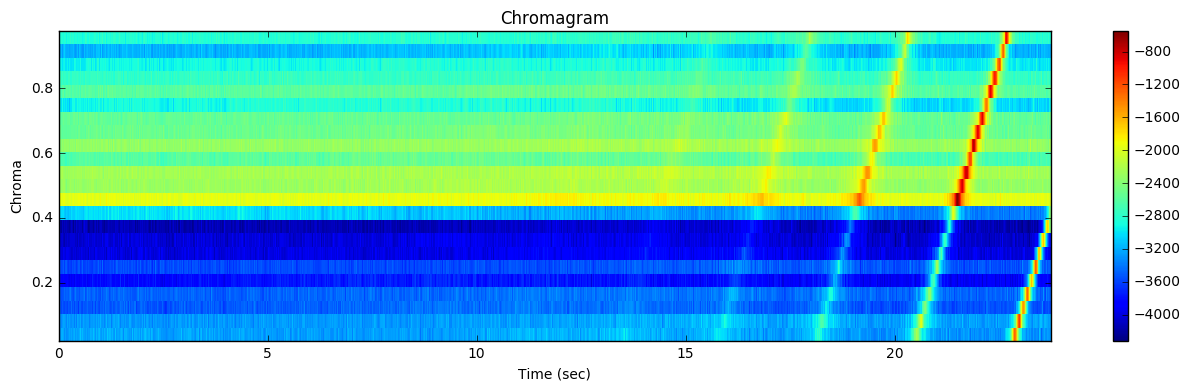

In [6]:
# do yourself a favor and write something to test your chromagram here.
sinesweep, sr = librosa.load('sinesweep.wav', sr=44100)
cgram, times, chroma = chromagram(sinesweep, 2048, 1024, 44100, 24, display=True)


# librosa test
# S = np.abs(librosa.stft(sinesweep, n_fft=4096))**2
# chroma = librosa.feature.chroma_stft(S=S, sr=sr)
# import matplotlib.pyplot as plt
# librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('Chromagram')
# plt.tight_layout()

#### 3. (2 point) Make a mel-frequency cepstrogram.  In lecture we mentioned the plain (not mel frequency) cepstrum of a time-domain signal $s$ can be calculated as follows:

$ cepstrum = ifft(log|fft(s)|)$

#### For audio processing, we typically don't use the FFT, but the mel-spectrogram. This means we've removed the frequencies above the Nyquist rate and therefore, things can get a little bit weird when taking the inverse FFT. A very common approach to dealing with this weirdness is to use an alternate transform called the Discrete Cosine Transform (DCT). You don't have to understand the details for this assignment , but you can find out more about cesptrums in the paper reading coming up in the 2nd half of the class.  Anyhow, now the cepstrum looks more like this:

1. Get the spectrum S = fft(s)
2. make a mel-spaced magnitude spectrum M from S, discarding frequencies above Nyquist
3. make M' = log(M)
4. do DCT(M') 

#### This is the approach we'd like you to take in making a mel-frequency cepstrogram. 

#### You can find a DCT implementation to use here:
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.dct.html


In [7]:
def mf_cepstrogram(signal, window_size, hop_size, sample_rate, num_channels, display = True ):
    """
    Builds a mel-frequency cepstrogram. Computes the short term fourier transform of a 1-D numpy array 
    (the signal). It then creates a magnitude spectrogram of the signal and then remaps the energy num_channels
    frequency bins, spaced evenly in the mel frequency domain between the top key of the piano (4186 Hz) and 
    the bottom key of the piano (27.5 Hz). It then takes the DCT of the log of each magnitude spectrum. The 
    vertical dimension is the index number of the cepstral coefficient. The horizontal dimension is time(in seconds), 
    brightness corresponds to magnitude.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    num_channels: how many mel-spaced frequency bins to put the energy into. 
                This becomes the number of cepstral coefficients.
    display: bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with the following items
    
    mfccgram: a 2-D numpy array of real-valued numbers that contains the mel frequency cepstrogram.
           mfccgram[t,c] is the magnitude at time t and cepstral coefficeint c. 
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
           
    Calling Example
    ---------------
    mfccgram,times = mf_cepstrogram(signal, window_size, hop_size, sample_rate, num_channels)

    """
    lgram, times, cfreqs = log_spectrogram(signal, window_size, hop_size, sample_rate, num_channels, channel_spacing='mel', display = False)
    lgram = 10**(lgram/20)
    mfccgram = np.zeros(lgram.T.shape)
    for t in range(len(times)):
        mfccgram[t] = sp.fftpack.dct(np.log(lgram.T[t] + 0.00000001))
         
    if display:
        y = np.linspace(0, num_channels, num_channels)
        
        plt.figure(figsize=[16,4])
        x_coord = np.tile(times,(len(y),1)) 
        y_coord = np.tile(y,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,mfccgram.T)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])
        plt.title('Mel-Frequency Cepstrogram')
        plt.xlabel('Time (sec)')
        plt.ylabel('Index of Cepstrual Coefficient')
        cbar = plt.colorbar()
    
    return mfccgram, times

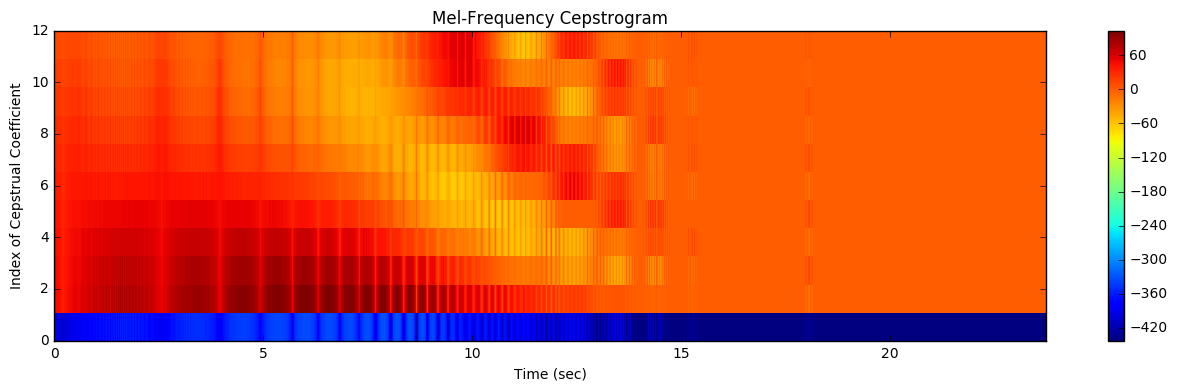

In [8]:
## testing cepstrogram
mfccgram, times = mf_cepstrogram(sinesweep, 2048, 1024, 44100, 12, display=True)

## Starting with Question 4, it is OK to use any function from librosa to do your work.

#### 4. (1 point) The recordings "balloon_center.wav" and "balloon_stage.wav" are of balloon pops recorded in Ryan Auditorium in front of the class. The microphone was placed at the center of the auditorium. For the first recording the balloon was popped very close to the microphone, while for the second one the balloon was popped on the stage, far from the microphone. Assume that the balloon pops were perfect impulses and that the recordings made were perfect recordings of the resulting sound in the room. Explain how to use these recordings to estimate the impulse response of the room. Then add the sound of the auditorium's reverberation to the dry (no reverb) recording "trumpet.wav" using both recordings (we talked about two different methods for filtering a signal in class, use the one with less computational complexity). Listen to the results and describe any similarities or differences you notice between the two reverbed sounds.

We can use the formula, H = Y / X, (H = impulse response, Y = recording, X = impulse function). Since we are assuming perfect impulses and recordings, X is all 1s and we are left with the formula H = Y.  This means that the impulse response equals the recorded sound. You can take the Fourier transform of the recorded sound Y will give you the impusle response (given our assumptions of a perfect impusle function). 

After listening to both stage and center recordings, I noticed that both recordings contain the echoing reverb effect. Between the two recordings, the stage reverb has a much stronger reverberation pattern. The increase in echo makes sense because the balloon recording on the stage was further away from the balloon recording at the center of the auditorium, and picked up a lot more reverberation on its recording. 

In [9]:
## my code for problem 4
balloon_center, sr = librosa.load('ryan_auditorium_recordings/balloon_center.wav', sr=44100)
balloon_stage, sr = librosa.load('ryan_auditorium_recordings/balloon_stage.wav', sr=44100)
trumpet, sr = librosa.load('trumpet.wav', sr=44100)

trumpet_center = sp.signal.fftconvolve(balloon_center, trumpet)
trumpet_stage = sp.signal.fftconvolve(balloon_stage, trumpet)


Audio(trumpet_center, rate=sr)

In [10]:
Audio(trumpet_stage, rate=sr)

#### 5. (1 points) Now explain what possible sources of error there are that might mess up the approach to estimating the auditorium's impulse  response described in Question 4 and how you would go about reducing or eliminating these sources of error in your impulse response estimation.

One possible source of error could be any background noise in the room during the recording (such as the sound of the air conditioner). To eliminate this, we could use binary time frequency masking to eliminate that frequency completely (if we knew what the frequency of the noise is). 

#### 6. (2 points)  Below is some code we have provided to estimate the impulse response of the auditorium using the sine sweep we played and recorded. Plot the frequency response function associated with this impulse response function. Plot the frequency response of the impulse response you got using the method in Question 4. Compare them. 

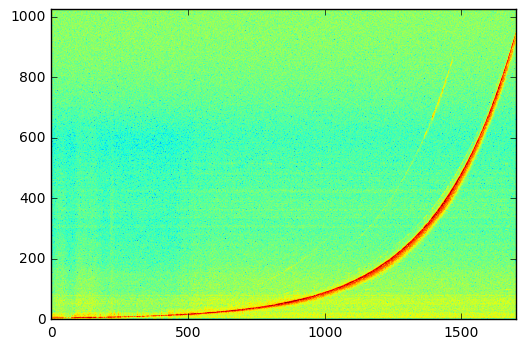

In [11]:
# load the sine sweep played out through the speaker in the auditorium
sine_sweep,sr = librosa.load('sinesweep.wav', 44100)
input_size=np.size(sine_sweep)

# load the recording made of the sine sweep in the auditorium
sine_sweep_recording,sr = librosa.load('ryan_auditorium_recordings/sinesweep_recording.wav', 44100)
output_size=np.size(sine_sweep_recording)

# plot an stft of the sine sweep recorded in the auditorium
plt.figure(); plt.imshow(20*np.log10(np.abs(librosa.stft(sine_sweep_recording))),origin='lower',aspect='auto')

# calculate the response of the inverse filter which will be used to extract the impulse response of the auditorium
# from the sine sweep recording
freq_range=np.linspace(20,20000,input_size)
envelope=freq_range[::-1]**3; 
inv_filt=envelope*sine_sweep[::-1]
inv_filt=inv_filt/max(np.abs(inv_filt))

# compute the minimum number of fft point required for filtering (to avoid cirucular convolution)
nfft=input_size+output_size-1
nfft=int(2**np.ceil(np.log2(nfft)))

# perform inverse filtering in the frequency domain 
inv_filt_fft=np.fft.fft(inv_filt,nfft)
recording_fft=np.fft.fft(sine_sweep_recording,nfft)
freq_response=inv_filt_fft*recording_fft
impulse_response=np.real(np.fft.ifft(freq_response))

# normalize the impulse response obtained through inverse filtering
impulse_response=impulse_response/max(np.abs(impulse_response))

# since the energy of the impulse response is concentrated at a very short duration (it's almost zero elsewhere)
# we need to trim it and extract the non-zero part

threshold=0.005 # this threshold was selected empirically
nonzero_idx=np.nonzero(impulse_response>threshold) 
start=nonzero_idx[0][0] # the first time amplitude passes the threshold 
stop=start+sr  # the effective length of the impulse response seems to be less than one second 

impulse_response=impulse_response[start:stop]



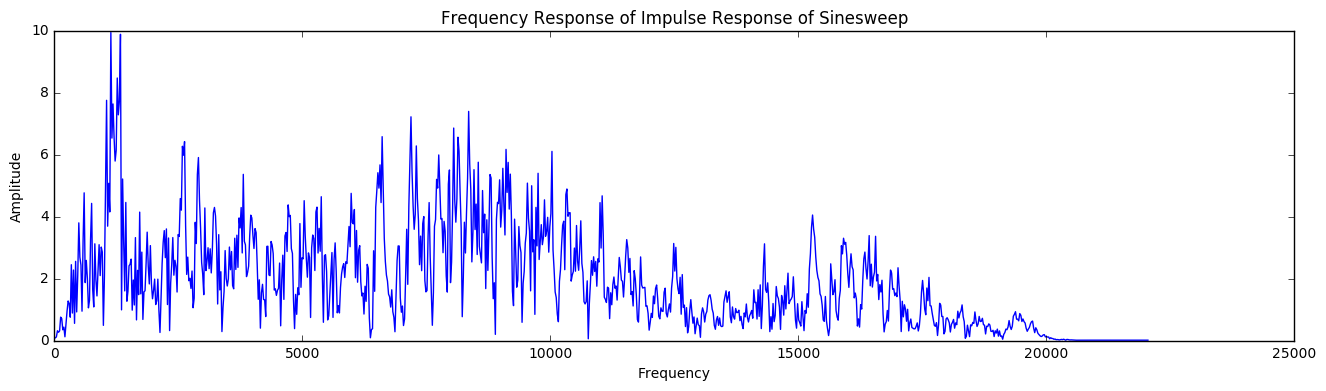

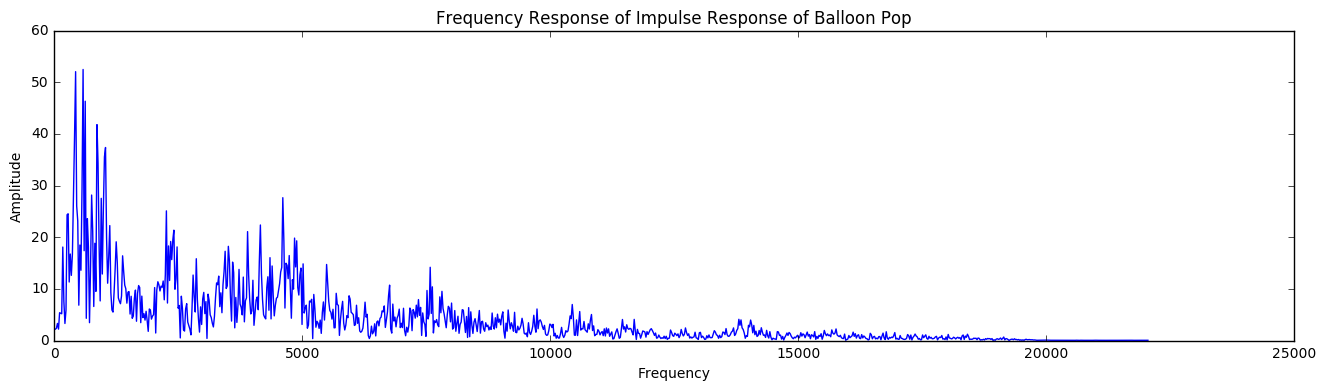

In [12]:
n_fft = 2048

# freq response from sinesweep impulse response
f = np.abs(np.fft.fft(impulse_response, n=n_fft))
freqs = librosa.core.fft_frequencies(sr=44100, n_fft=n_fft)
plt.figure(figsize = [16,4])
plt.title('Frequency Response of Impulse Response of Sinesweep')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freqs, f[0:(n_fft/2)+1])


# freq response from balloon pop impulse response
b = np.abs(np.fft.fft(balloon_stage, n=n_fft))
freqs = librosa.core.fft_frequencies(sr=44100, n_fft=n_fft)
plt.figure(figsize = [16,4])
plt.title('Frequency Response of Impulse Response of Balloon Pop')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freqs, b[0:(n_fft/2)+1])

#### 7. (1 points) Use the sine-sweep-derived impulse response to add reverb to "trumpet.wav". Also use the approach you described in Question 4 to add reverb to trumpet.wav. Which sounds better? Listen to the audio file "trumpet_natural_reverb.wav", which was actually recorded in the auditorium and compare it to the reverbed samples you have made using the impulse response of the auditorium. Note...it is ok for this problem to trim an impulse response or trim the trumpet file a touch so that they are the same length. 

After comparing the trumpet with reverb from the sine sweep versus the trumpet with reverb from the balloon pop, the sinesweep convolution sounds much more clear. I think this is because the sine sweep recording contains the impulse response from the entire frequency range compared to the impulse response of the balloon, which covers a much smaller frequency range. The sine sweep also sounded much more clear than the recorded trumpet with reverb in the auditorium. 

In [13]:
trumpet, sr1 = librosa.load('trumpet.wav', 44100, duration=11)

trumpet_sinesweep = sp.signal.fftconvolve(impulse_response, trumpet)

Audio(trumpet_sinesweep, rate=sr1)

In [14]:
trumpet_reverb,sr = librosa.load('ryan_auditorium_recordings/trumpet_natural_reverb.wav', 44100)
Audio(trumpet_reverb, rate=sr)

#### 8. (1 point) Go on Youtube and listen to the musical piece "I am sitting in a room" by Alvin Lucier. Research the piece on the web. Give your reaction to the piece. Explain how it was created. 

"I am sitting in a room" was first recorded by Alvin Lucier in 1969.  It was created by Lucier speaking within a room.  He recorded that speech and replayed it in the same room, and continued to repeat this process of recorded and playing-back until the only thing that remains are the resonant frequencies of the room itself. Lucier has stated that this piece can be reperformed by anyone in any room with any spoken text, as to reveal what the room's resonant harmonies sound like. 

I really enjoyed listening to Lucier's piece. It was very fascinating hearing the subtle differences between each consecutive rerecording, and then later hearing the stark differences between the original recording and what the piece sounds like at the end, where only the resonant harmonies of the room are distinguishable rather than Lucier's spoken dialogue.

#### 9. (2 points) Recreate Alvin Lucier's piece by recording your voice saying the text of the piece ONCE. Then repeatedly use an impulse response function (you can choose any of the provided impulse responses) applied to the signal, duplicating the effect of Lucier's piece without having to keep re-recording in the physical world. NOTE you may have issues to deal with in terms of normalization or length of impulse response function vs length of the recording. You're going to have to figure out those out. 

In [ ]:
sr = 44100
me_start, sr = librosa.load('sitting_in_a_room.wav', sr)

add = me_start
me_end = me_start

for i in range(15):
    np.resize(add, me_start.shape)
    add = sp.signal.fftconvolve(impulse_response, add)
    add /= np.max(np.abs(add))
    me_end = np.append(me_end, add.copy())

wavwrite('sitting_in_a_room_new.wav', me_end, sr)

final_result, sr = librosa.load('sitting_in_a_room_new.wav', sr)
Audio(final_result, rate=sr)

#### 10. (1 point) Pick one paper (your choice) from the list of papers on the course home page. Give a 300 word review of the paper. What is the paper about? What did you learn? What was confusing? What was interesting?

I read over Cory McKay and Ichiro Fujinaga’s paper, “Automatic Genre Classification Using Large High-Level Musical Feature Sets."  The paper focuses on how MIDI feature sets were used to classify a recording into a specific genre using different classification techniques, like k-nearest neighbors, and feedforward neural networks.  The actual selection of features was performed using genetic algorithms.  Since musical genres themselves fall under a hierarchical structure, the classification itself was done in a similar manner by beginning with a “root genre”, and then specifying to more specific “leaf” genres.  By selecting feature sets that varied between different genres, the classifier was able to predict with great accuracy a given recording root and leaf genre.  Increasing the number of candidate features also proved to improve the accuracy of classification as well.

While reading McKay and Fujinaga’s research, I was very interested in their description of how to create the most useful feature set.  I enjoyed learning about how they used their knowledge of musical form and structure to try and pin down what types of characteristics to focus on when looking at the features.  They noted how instrumentation, musical texture, rhythm, dynamics, pitch statistics, melody, and chords were the seven categories of features that were used to classify in their system. I found it very interesting how their system used these categories to do their classification.  By picking distinct features for each type of musical genre, they were able to classify a given recording with a very high success rate.  Given the wide range of music genre throughout the world, and the increasingly growing digital musical catalogue, I enjoyed reading how Mckay and Fujinaga’s research could be useful in helping organize music into their respective genres. 

I was a little confused, however, about how the study decided to focus on the three different “root” genres and their respective “leaf” genres.  While it is referenced that the other research studies included in the paper helped inspire which genres to focus on, the paper does not go into great detail exactly how this is done.  I would like to learn more about what makes these genres distinct, with perhaps greater details about which features would help distinguish between the three genres. 